# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 400000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (400000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
filtered_data['Score'].value_counts()

1    337081
0     62919
Name: Score, dtype: int64

In [9]:
#Sorting data according to ProductId in ascending order
filtered_data=filtered_data.sort_values('Score', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Sorting data according to Time in ascending order
sorted_data=filtered_data[:126000].sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(102681, 10)

In [12]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'][:126000].size*1.0)*100

81.49285714285715

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [13]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [14]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [15]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(102681, 10)


1    57446
0    45235
Name: Score, dtype: int64

In [16]:
final.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [17]:
x=final.drop('Score',axis=1)
y=final.filter(['Score'],axis=1)

In [18]:
x_tr=x[:50313]
y_tr=y[:50313]
x_cv=x[50313:71876]
y_cv=y[50313:71876]
x_test=x[71876:]
y_test=y[71876:]

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [19]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION!
Traditional Medicinals Echinacea Plus is an herbal remedy in tea form designed to support the immune system.  Echinacea is a Native American herb and is one of the most commonly used herbal medicines in the US and Europe.  This tea delivers the immune boosting properties of organic Echinacea in a pleasant tasting blend of organic West Indian lemongrass leaf and organic spearmint.  Echinacea Plus has a serene and subtle lemon-mint flavor that is exceptionally comforting for colds, and soothing to scratchy raw throats.  Echinacea provides a slight tingle on the tongue due to the presence o

In [20]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION!


In [21]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION!
Traditional Medicinals Echinacea Plus is an herbal remedy in tea form designed to support the immune system.  Echinacea is a Native American herb and is one of the most commonly used herbal medicines in the US and Europe.  This tea delivers the immune boosting properties of organic Echinacea in a pleasant tasting blend of organic West Indian lemongrass leaf and organic spearmint.  Echinacea Plus has a serene and subtle lemon-mint flavor that is exceptionally comforting for colds, and soothing to scratchy raw throats.  Echinacea provides a slight tingle on the tongue due to the presence o

In [22]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [23]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Limp, soggy, little taste. Not a bit like real pad Thai.


In [24]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I, myself always enjoyed this movie, it's very funny and entertaining, so I didn't hesitate to pick up the clamshell edition.  I guess it was a marketing plan to make the movie more for families or something, but they  have eliminated all strong profanity and elements that are usually edited  in the television version.  YOU HAVE BEEN WARNED.  If you want the uncut  version, AVOID THE CLAMSHELL EDITION!


In [25]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Limp soggy little taste Not a bit like real pad Thai 


In [26]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

#### PREPROCESSING OF TRAIN DATA

In [27]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(x_tr['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 50313/50313 [00:42<00:00, 1187.33it/s]


In [28]:
preprocessed_reviews[1500]

'limp soggy little taste not bit like real pad thai'

#### PREPROCESSING OF CV DATA

In [29]:
from tqdm import tqdm
preprocessed_reviews_cv = []
# tqdm is for printing the status bar
for sentance in tqdm(x_cv['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_cv.append(sentance.strip())

100%|██████████████████████████████████████████████████████████████████████████| 21563/21563 [00:18<00:00, 1153.34it/s]


#### PREPROCESSING OF TEST DATA

In [30]:

from tqdm import tqdm
preprocessed_reviews_test = []
# tqdm is for printing the status bar
for sentance in tqdm(x_test['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews_test.append(sentance.strip())#### PREPROCESSING OF TEST DATA

100%|██████████████████████████████████████████████████████████████████████████| 30805/30805 [00:26<00:00, 1172.84it/s]


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [31]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

#### VECTORIZING FOR  TRAIN DATA IN BOW

In [32]:
#BoW
count_vect = CountVectorizer(max_features=28000) #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaaa', 'aaaaaaarrrrrggghhh', 'aaaaaahhhhhyaaaaaa', 'aaah', 'aaahhh', 'aaahs', 'aachen']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50313, 28000)
the number of unique words  28000


#### VECTORIZING FOR CV DATA IN BOW

In [33]:
#BoW
count_vect.fit(preprocessed_reviews_cv)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_cv = count_vect.transform(preprocessed_reviews_cv)
print("the type of count vectorizer ",type(final_counts_cv))
print("the shape of out text BOW vectorizer ",final_counts_cv.get_shape())
print("the number of unique words ", final_counts_cv.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaa', 'aaaallll', 'aachener', 'aafco', 'aarp', 'ab', 'aback', 'abandoed']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (21563, 28000)
the number of unique words  28000


#### VECTORIZING FOR TEST DATA IN BOW

In [34]:
 #in scikit-learn
count_vect.fit(preprocessed_reviews_test)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts_test= count_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_counts_test))
print("the shape of out text BOW vectorizer ",final_counts_test.get_shape())
print("the number of unique words ", final_counts_test.get_shape()[1])

some feature names  ['aa', 'aaa', 'aaaaa', 'aaaaallll', 'aaaahhhhhh', 'aadd', 'aafco', 'aafes', 'aah', 'aamazon']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (30805, 28000)
the number of unique words  28000


## [4.2] Bi-Grams and n-Grams.

In [35]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (50313, 5000)
the number of unique words including both unigrams and bigrams  5000


## [4.3] TF-IDF

#### TF-IDF FOR TRAIN DATA

In [36]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10,max_features=10000)
tf_idf_vect.fit_transform(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able make', 'able order', 'able purchase', 'able use']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (50313, 10000)
the number of unique words including both unigrams and bigrams  10000


#### TF-IDF FOR CV DATA

In [37]:
# tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit_transform(preprocessed_reviews_cv)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_cv = tf_idf_vect.transform(preprocessed_reviews_cv)
print("the type of count vectorizer ",type(final_tf_idf_cv))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_cv.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_cv.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able drink', 'able eat', 'able enjoy', 'able find', 'able get', 'able make', 'able order']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (21563, 10000)
the number of unique words including both unigrams and bigrams  10000


#### TF-IDF FOR TEST DATA

In [38]:
tf_idf_vect.fit_transform(preprocessed_reviews_test)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf_test = tf_idf_vect.transform(preprocessed_reviews_test)
print("the type of count vectorizer ",type(final_tf_idf_test))
print("the shape of out text TFIDF vectorizer ",final_tf_idf_test.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf_test.get_shape()[1])

some sample features(unique words in the corpus) ['abdominal', 'ability', 'able', 'able buy', 'able eat', 'able find', 'able get', 'able make', 'able order', 'able use']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (30805, 10000)
the number of unique words including both unigrams and bigrams  10000


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using absolute values of `coef_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

C:\Users\Ankit Mishra\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [40]:
alp=[10**-4,10**-3,10**-2,10**-1,1,10**2,10**3,10**4,10**5,10**6]

In [41]:

auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]

for i in alp:
    nb = MultinomialNB(alpha=i)
    # fitting the model on crossvalidation train
    nb.fit(final_counts, y_tr)
    
    # predict the response on the crossvalidation train
    pred = nb.predict_proba(final_counts_cv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, pred)
    auc=metrics.auc(fpr, tpr)
    auc_cv.append(auc)
    tpr_cv.append(tpr)
    fpr_cv.append(fpr)
    
    # predict the response on the train
    pred = nb.predict_proba(final_counts)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, pred)
    auc=metrics.auc(fpr, tpr)
    auc_tr.append(auc)
    tpr_tr.append(tpr)
    fpr_tr.append(fpr)

    
#AUC
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [42]:
data1={'alpha':alp,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

In [43]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,alpha,auc_cv,auc_tr
5,100.0,0.550457,0.872963


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

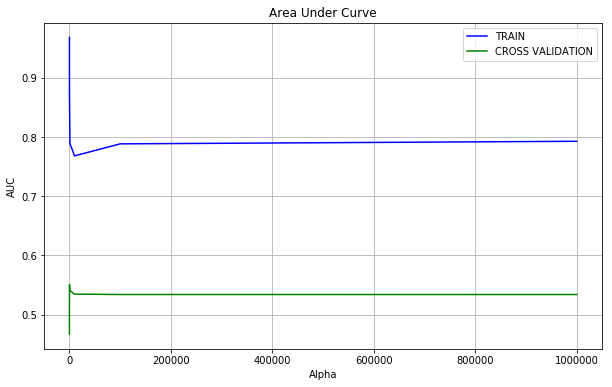

In [44]:
plt.figure(figsize=(10,6))
plt.plot(alp,auc_tr,'b',label='TRAIN')
plt.plot(alp,auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('Alpha')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [45]:
# TESTING THE MODEL ON TEST DATA
nb_final=MultinomialNB(alpha=100)
nb_final.fit(final_counts,y_tr)
pred_final=nb_final.predict_proba(final_counts_test)[:,1]
fpr_f, tpr_f, thresholds_f=metrics.roc_curve(y_test, pred_final)
auc_final=metrics.auc(fpr_f, tpr_f)
auc_final

0.51689952134101436

In [46]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=nb_final.predict_proba(final_counts)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.87296288228407171

In [47]:
y_test.shape

(30805, 1)

In [48]:
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random(1,[0,1]))




In [49]:
pred_final_class.count(0),pred_final_class.count(1)

(26398, 4407)

### ROC CURVE

In [50]:
y_a=[0,0.5,1]
x_a=y_a

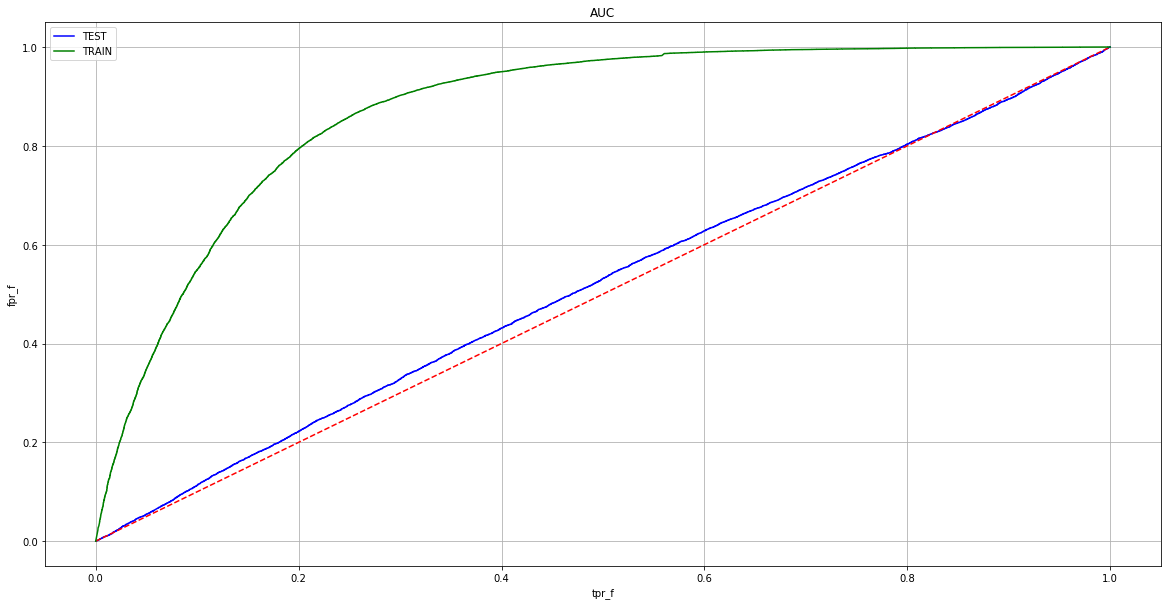

In [51]:
plt.figure(figsize=(20,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [52]:
cm = confusion_matrix(y_test['Score'], pred_final_class)
cm

array([[12658,  1952],
       [13740,  2455]], dtype=int64)

In [53]:
y_test["Score"].value_counts()

1    16195
0    14610
Name: Score, dtype: int64

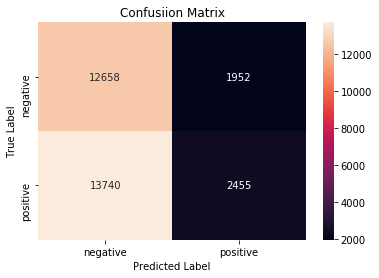

In [54]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [55]:
print(classification_report(y_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.48      0.87      0.62     14610
          1       0.56      0.15      0.24     16195

avg / total       0.52      0.49      0.42     30805



### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [64]:
max_ind_pos=np.argsort((nb_final.feature_log_prob_)[1])[::-1][0:10]

In [69]:
for i in max_ind_pos:
# max_ind_pos
    print((nb_final.feature_log_prob_)[1][i])

-4.96775423651
-5.80780551216
-5.92709493966
-5.9683509732
-6.10434624561
-6.18694945727
-6.22740498031
-6.2933981348
-6.30629795998
-6.32603637043


In [56]:
log_prob = nb_final.feature_log_prob_
log_prob

array([[-10.47893546, -10.50849426, -10.50849426, ..., -10.50849426,
        -10.50849426, -10.50849426],
       [-10.53859123, -10.56786161, -10.56786161, ..., -10.56786161,
        -10.54825314, -10.56786161]])

In [416]:
bow_features = count_vect.get_feature_names()

In [417]:
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(28000, 2)

In [424]:
feature_prob_tr[1].sort_values(ascending = False)[0:10]

moneys          -4.967754
leisurely       -5.807806
grandchildren   -5.927095
guarantee       -5.968351
nettle          -6.104346
tends           -6.186949
textual         -6.227405
prescriptions   -6.293398
lineage         -6.306298
fingernail      -6.326036
Name: 1, dtype: float64

### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [70]:
max_ind_neg=np.argsort((nb_final.feature_log_prob_)[0])[::-1][0:10]

In [71]:
for i in max_ind_neg:
    print((nb_final.feature_log_prob_)[0][i])

-4.71648726001
-5.83510483941
-6.09921731521
-6.10617492644
-6.1136748079
-6.27758125937
-6.50589956076
-6.569829328
-6.58513574928
-6.59907464482


In [425]:
feature_prob_tr[0].sort_values(ascending = False)[0:10]

moneys          -4.716487
leisurely       -5.835105
without         -6.099217
tends           -6.106175
prescriptions   -6.113675
nettle          -6.277581
grandchildren   -6.505900
fingernail      -6.569829
mmmm            -6.585136
cfh             -6.599075
Name: 0, dtype: float64

## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [72]:
alp=[10**-4,10**-3,10**-2,10**-1,1,10**2,10**3,10**4]

In [73]:

auc_cv=[]
tpr_cv=[]
fpr_cv=[]
tpr_tr=[]
fpr_tr=[]
auc_tr=[]

for i in alp:
    nb = MultinomialNB(alpha=i)
    # fitting the model on crossvalidation train
    nb.fit(final_tf_idf, y_tr)
    
    # predict the response on the crossvalidation train
    pred = nb.predict_proba(final_tf_idf_cv)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_cv, pred)
    auc=metrics.auc(fpr, tpr)
    auc_cv.append(auc)
    tpr_cv.append(tpr)
    fpr_cv.append(fpr)
    
    # predict the response on the train
    pred = nb.predict_proba(final_tf_idf)[:,1]
    fpr, tpr, thresholds = metrics.roc_curve(y_tr, pred)
    auc=metrics.auc(fpr, tpr)
    auc_tr.append(auc)
    tpr_tr.append(tpr)
    fpr_tr.append(fpr)

    
#AUC
#  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html

In [74]:
data1={'alpha':alp,'auc_cv':auc_cv[:],'auc_tr':auc_tr[:]}
data_f=pd.DataFrame(data1)

In [75]:
data_f[data_f['auc_cv']==data_f['auc_cv'].max()]

,alpha,auc_cv,auc_tr
2,0.01,0.607402,0.965489


### AREA UNDER CURVE Vs Neighbours PLOT FOR TRAIN AND TEST

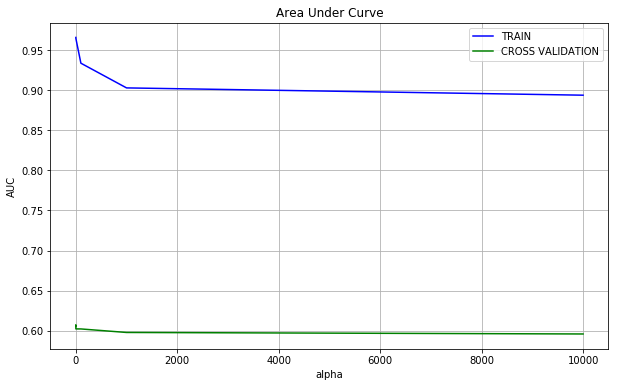

In [76]:
plt.figure(figsize=(10,6))
plt.plot(alp,auc_tr,'b',label='TRAIN')
plt.plot(alp,auc_cv,'g',label='CROSS VALIDATION')
plt.xlabel('alpha')
plt.ylabel('AUC')
plt.title('Area Under Curve')
plt.grid()
plt.legend()
plt.show()

In [77]:
# TESTING THE MODEL ON TEST DATA
nb_final=MultinomialNB(alpha=0.01)
nb_final.fit(final_tf_idf,y_tr)
pred_final=nb_final.predict_proba(final_tf_idf_test)[:,1]
fpr_f, tpr_f, thresholds_f=metrics.roc_curve(y_test, pred_final)
auc_final=metrics.auc(fpr_f, tpr_f)
auc_final

0.6332135111541638

In [78]:
# TESTING THE MODEL ON TRAIN DATA
pred_train=nb_final.predict_proba(final_tf_idf)[:,1]
fpr_ft, tpr_ft, thresholds_ft=metrics.roc_curve(y_tr, pred_train)
auc_finalt=metrics.auc(fpr_ft, tpr_ft)
auc_finalt

0.96548866533084698

### ROC CURVE

In [79]:
y_a=[0,0.5,1]
x_a=y_a

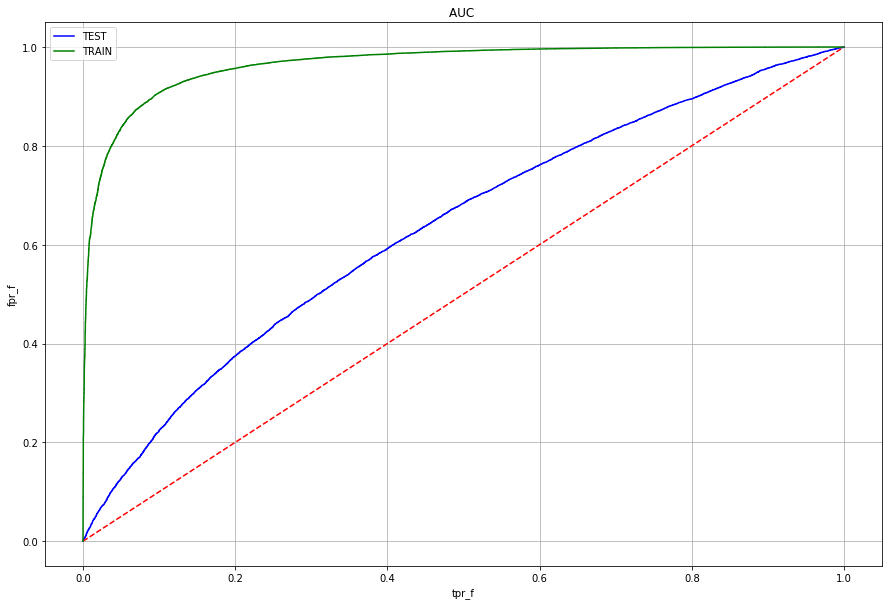

In [80]:
plt.figure(figsize=(15,10))
plt.plot(fpr_f,tpr_f,'b',label='TEST')
plt.plot(x_a,y_a,'--r')
plt.plot(fpr_ft,tpr_ft,'g',label='TRAIN')
plt.xlabel('tpr_f')
plt.ylabel('fpr_f')
plt.title('AUC ')
plt.grid()
plt.legend()
plt.show()

### CONFUSION MATRIX

In [81]:
pred_final
pred_final_class=[]
for i in range(len(pred_final)):
    if pred_final[i]>0.5:
        pred_final_class.append(1)
    elif pred_final[i]<0.5:
            pred_final_class.append(0)
    else:
            pred_final_class.append(np.random(1,[0,1]))




In [82]:
cm = confusion_matrix(y_test, pred_final_class)
cm

array([[ 5487,  9123],
       [ 3565, 12630]], dtype=int64)

In [83]:
y_test["Score"][:500].value_counts()

0    258
1    242
Name: Score, dtype: int64

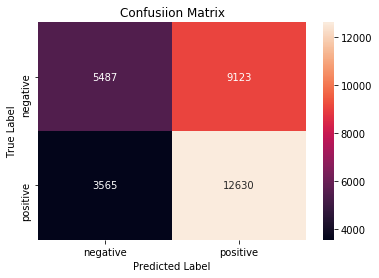

In [84]:
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

## CONCLUSION

In [85]:
print(classification_report(y_test, pred_final_class))

             precision    recall  f1-score   support

          0       0.61      0.38      0.46     14610
          1       0.58      0.78      0.67     16195

avg / total       0.59      0.59      0.57     30805



### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [86]:
max_ind_pos=np.argsort((nb_final.feature_log_prob_)[1])[::-1][0:10]

for i in max_ind_pos:
# max_ind_pos
    print((nb_final.feature_log_prob_)[1][i])

In [87]:
for i in max_ind_pos:
# max_ind_pos
    print((nb_final.feature_log_prob_)[1][i])

-5.0959823548
-5.281613647
-5.4271199355
-5.53714834778
-5.53806496013
-5.54833946073
-5.62990951888
-5.73056962003
-5.73388470038
-5.75695938198


In [90]:
log_prob = nb_final.feature_log_prob_
tfidf_features = tf_idf_vect.get_feature_names()

In [91]:
feature_prob = pd.DataFrame(log_prob, columns = tfidf_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(10000, 2)

In [92]:
feature_prob_tr[1].sort_values(ascending = False)[0:10]

not big              -5.095982
grape                -5.281614
going try            -5.427120
tasted awful         -5.537148
less water           -5.538065
looked good          -5.548339
coffee bean          -5.629910
product absolutely   -5.730570
one bit              -5.733885
tablets              -5.756959
Name: 1, dtype: float64

### [5.2.2] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [94]:
max_ind_neg=np.argsort((nb_final.feature_log_prob_)[0])[::-1][0:10]

In [99]:
for i in max_ind_neg:
# max_ind_pos
    print((nb_final.feature_log_prob_)[0][i])

-4.54206942833
-5.30543395155
-5.41730319924
-5.43029298517
-5.46787602807
-5.68352924843
-5.69402738244
-5.8184845059
-5.84057037371
-5.87000410833


In [100]:
feature_prob_tr[0].sort_values(ascending = False)[0:10]

not big              -4.542069
less water           -5.305434
product absolutely   -5.417303
tablets              -5.430293
would add            -5.467876
one bit              -5.683529
coffee bean          -5.694027
fishy smell          -5.818485
no exception         -5.840570
going try            -5.870004
Name: 0, dtype: float64

# [6] Conclusions

In [101]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["VECTORIZER", "HYPERMETER", "AUC"]

x.add_row(["BOW", 100, 0.51690])
x.add_row(["TFIDF", 0.01,0.63321351])



In [102]:
print(x)

+------------+------------+------------+
| VECTORIZER | HYPERMETER |    AUC     |
+------------+------------+------------+
|    BOW     |    100     |   0.5169   |
|   TFIDF    |    0.01    | 0.63321351 |
+------------+------------+------------+
